# MATTE User Guide
The user guide will talk about how the pipeline is implemented and how to modified pipeline or setup a custom pipeline.

## Overview of MATTE

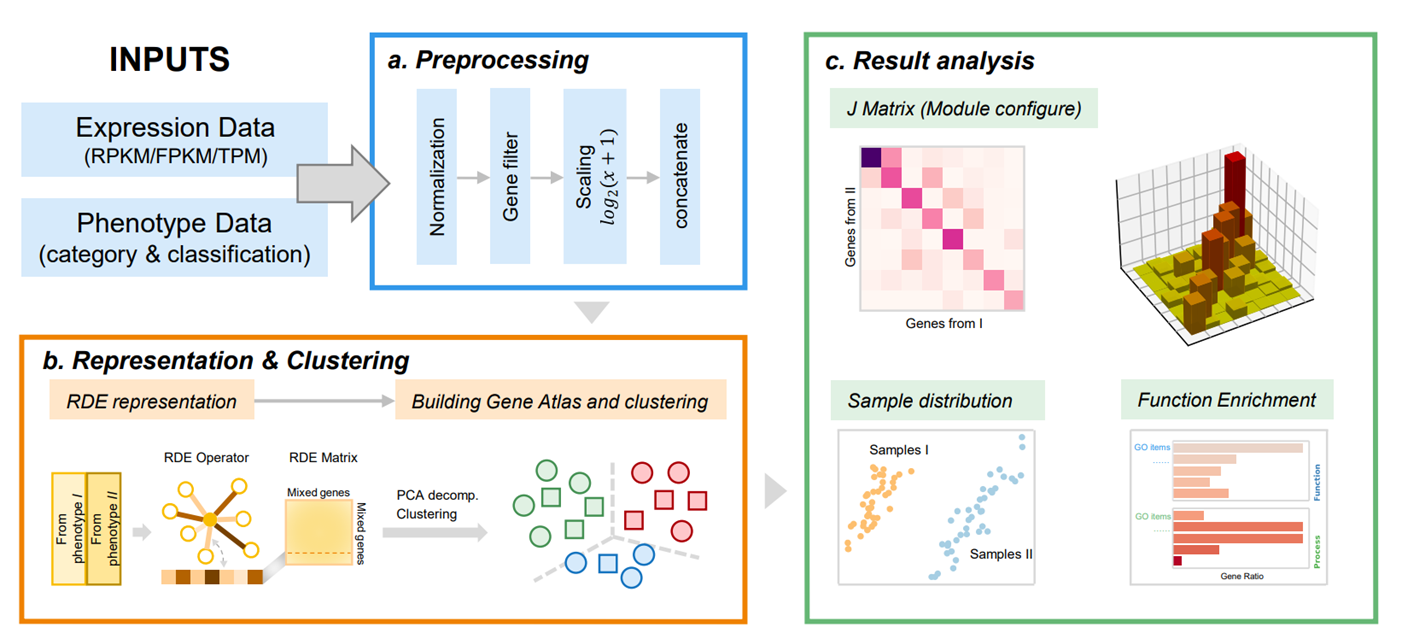
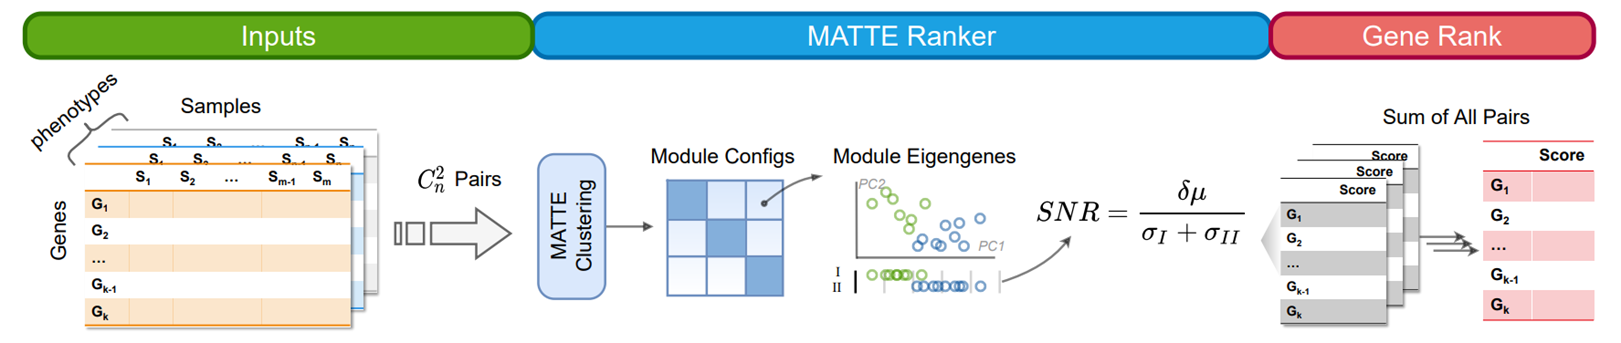

## Gene clustering process

Broadly speaking, there are three steps:

1. preprocessing
2. clustering
3. Module analysis

The results that each of these parameters can lead to and produce will be described in detail in the following three procedures.

### Pipeline design
`PipeFunc` is a most basic class in MATTE python package. The class store a function and it's arguments but **not run it** until calling it like calling a funtion. And a `Pipefunc` will show it's arguments and name by `print(PipeFunc)` or `str(PipeFunc)`. The string will be updated everytime parameters are added by `add_params`, but not when being called. When you call it, stored arguments can be ellipsised. But arguments you put in will also be considered.

In a `AlignPipe` class, there are several `PipeFunc` and `transformer`. Here, `transformer` means object that has `fit` and `transform` methods. When calling `AlignPipe.calculate`, `PipeFunc` and `transformer` will be performed one by one. All `funcs` are stored in `AlignPipe.funcs` attributes and `AlignPipe.cluster_func` attributes. One can use build-in function `add_steps` to add a **preprocessing** step into `AlignPipe.funcs` and `set_cluster_method` to add **clustering** step into `AlignPipe.cluster_func`. These two are `list` object that store `PipeFunc` and `transformer`. You can also add parameters by `add_param`, (in this step, a new function that return a dict contain param value and name will be generated) add transformer by `add_transformer`. When you create a `AlignPipe` object, by setting `init=True`, default pipeline will be created. *All functions in the pipeline should return a dict object*,(all these returns are saved in a dict `temp_result`) and by this way its return will be record and use in the following functions.

There are four methods to run pipeline, `calculate` and `fit_transform` is the same, but `fit_transform` has a parameters that allow save temp result. The saved temp dict object can be used in `calculate_from_temp`, where only clustering functions will be performed. And `transform` will not fit the data but use fitted transformers in the pipeline. If you want to use attributes of transformers, use `get_attribute_from_transformer`.

Some key temps are following: 
* When running the pipeline, before clustering there should generate a object named "before_clustering_df" to used in the `cluster_fun`. 
* And in the preprocessing steps, return object named "df_exp" to corver input. 
* When using `CrossCluster` object to perform clustering, `cluster_label` and `cluster_properties` will be passed to `build_results`
* And `build_results` will return a object named `Result`.

For convenience, a decorator `utils.kw_decorator` is used in most of functions in pipeline. It makes a fucntion return a dict according to parameter `kw`(str or list), and **the function will accept additional parameters** but not raise error.

### Preprocessing

Key function in preprocessing is `Kernel_transform`, who perform mostly important relative differential expression. Some kernel transform is implemented: 'mean','median' and 'corr'. For normal, mean kernels is recommended, but with outliers median function may have a better performance. After kernel matrix calculation, a `double_centering` and `sklearn.preprocessing.KernelCenterer` will be performed by default. In the previous test, these two will make results get more score, but may change in your case.

Other functions' detail can be seen in API page, `exp_filter` filter out genes with extremely low expression(custom function is allowed too), and `RPKM2TPM` is an important normalization preprocessing steps. Keeping default preprocessing steps is highly recommended.

### Clustering

`CrossCluster` is clustering function or clusterer warpper. There are three pre-implemented methods: `kmeans`(wrapper from `Bio.Cluster.kclust`),`spectrum` and `spectral_bicluster`(wrapper from `sklearn` implemention). So other keywords parameters should seen in the original implemention. In spectrum clustering, by default will calculate distance matrix first(parameter `use_aff`). If not using preset implemention, by `build_from_func` or `build_from_model` to set up clustering methods.

## Gene Ranker

GeneRanker accept more than two phenotypes, and will use pipeline to calculate pairs of phenotypes one by one, fincally sum/concatenate the results. Inputs of ModuleEmbedder is not the same as pipeline. Row of Expression data is sample, column is gene. 

There are two types of ranking :

There are several types of GeneRanker: 
1. 'module' and 'gene'

will cluster genes according to their expression. And Use module SNR to rank genes. In gene mode, the SNR will be corrected by the correlation of gene expression and module eigen. 

2. 'dist','cross-dist'. 

In dist mode, the distance of each genes will be calculated. And genes will be ranked according to the sum of distance to each other genes. In cross-dist mode, the distance of differential expression and differential co-expression will be merged.